Name - Alon Malach <br/>
ID - 207024878

#initial settings

In [1]:
#from __future__ import print_function
from google.colab import auth
from google.cloud import bigquery
from google.cloud.bigquery import magics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
auth.authenticate_user()

In [3]:
#@title Fill out this form then press [shift ⇧]+[enter ⏎] {run: "auto"}
import subprocess
import re

analysis_project = 'named-griffin-348712'  #@param {type:"string"}

In [4]:
admissions_table = f'physionet-data.mimic_core.admissions'
d_labitems_table = f'physionet-data.mimic_hosp.d_labitems'
labevents_table = f'physionet-data.mimic_hosp.labevents'
patients_table = f'physionet-data.mimic_core.patients'
d_icd_diagnoses_table = f'physionet-data.mimic_hosp.d_icd_diagnoses'
diagnoses_icd_table = f'physionet-data.mimic_hosp.diagnoses_icd'
icustays_table = f'physionet-data.mimic_icu.icustays'
top40_labs_table = f'named-griffin-348712.MIMIC.top40_labs'


# Preprocess queries made with the %%bigquery magic
# by substituting these values
sub_dict = {
    'icustays_table':icustays_table,
    'd_icd_diagnoses_table': d_icd_diagnoses_table,
    'diagnoses_icd_table': diagnoses_icd_table,
    'analysis_project': analysis_project,
    'admissions_table': admissions_table,
    'd_labitems_table': d_labitems_table,
    'labevents_table': labevents_table,
    'patients_table': patients_table,
    'top40_labs_table' : top40_labs_table,
    'ml_table_prefix': analysis_project + '.MIMIC.models_'
}

# Set the default project for running queries
magics.context.project = analysis_project

In [5]:
# Set up the substitution preprocessing injection
original_run_query = magics._run_query
def format_and_run_query(client, query, job_config=None):
  query = query.format(**sub_dict)
  #return original_run_query(client, query, job_config)
  return original_run_query(client, query, job_config)

#bigquery.magics._run_query = format_and_run_query
magics._run_query = format_and_run_query

print('analysis_project:', analysis_project)
print()
print('custom %%bigquery magic substitutions:')
for k, v in sub_dict.items():
  print(' ', '{%s}' % k, '→', v)

analysis_project: named-griffin-348712

custom %%bigquery magic substitutions:
  {icustays_table} → physionet-data.mimic_icu.icustays
  {d_icd_diagnoses_table} → physionet-data.mimic_hosp.d_icd_diagnoses
  {diagnoses_icd_table} → physionet-data.mimic_hosp.diagnoses_icd
  {analysis_project} → named-griffin-348712
  {admissions_table} → physionet-data.mimic_core.admissions
  {d_labitems_table} → physionet-data.mimic_hosp.d_labitems
  {labevents_table} → physionet-data.mimic_hosp.labevents
  {patients_table} → physionet-data.mimic_core.patients
  {top40_labs_table} → named-griffin-348712.MIMIC.top40_labs
  {ml_table_prefix} → named-griffin-348712.MIMIC.models_


In [6]:
%config InlineBackend.figure_format = 'svg'

In [7]:
bq = bigquery.Client(project=analysis_project)

In [8]:
def run_query(query):
  project_id = analysis_project
  df = pd.read_gbq(query, project_id=project_id, dialect='standard')
  return df

#2. Model Learning

###1+2.Take lab results from the first 4 hours of ICU admission, as well as demographic data including gender, age, admission type, admission location, insurance, marital status, and ethnicity. Limit to 40 most common labs.

In [10]:
%%bigquery top40labs_first4hours
WITH top_labs AS (
  SELECT COUNT(*) AS count, itemid FROM `{labevents_table}`
  WHERE hadm_id IS NOT NULL 
  GROUP BY itemid
  ORDER BY count DESC LIMIT 40
)
SELECT top_labs.itemid, lab_ev.hadm_id, avg(lab_ev.valuenum) as value
FROM
top_labs JOIN `{labevents_table}` AS lab_ev USING (itemid)  
JOIN `{icustays_table}` AS stay USING (hadm_id)
WHERE lab_ev.charttime <= DATETIME_ADD(stay.intime, INTERVAL '4' HOUR)
and hadm_id IS NOT NULL and itemid IS NOT NULL 
group by top_labs.itemid, lab_ev.hadm_id

In [11]:
%%bigquery top40_labs
  SELECT COUNT(*) AS count, itemid FROM `{labevents_table}`
  WHERE hadm_id IS NOT NULL 
  GROUP BY itemid
  ORDER BY count DESC LIMIT 40

###get labs values for each addminsion:

In [13]:
labs_columns = list()
lab_id = []
for _, row in top40_labs.iterrows():
    labs_columns.append('MAX(IF(itemid = {0}, 1, NULL))'
                             ' as `lab_{0}`'.format(row.itemid))
    lab_id += [row.itemid]

In [14]:
query2 = """
WITH labs AS (
SELECT
    HADM_ID,
    {lab_cols}
FROM `{labevents_table}` labeve INNER JOIN `{icustays_table}` stay USING (hadm_id)
WHERE itemid IS NOT NULL and labeve.charttime <= DATETIME_ADD(stay.intime, INTERVAL '4' HOUR)
GROUP BY HADM_ID
)


SELECT
patients.GENDER as gender,
anchor_age AS age,
adm.ADMISSION_TYPE as adm_type,
adm.admission_location as adm_location,
adm.INSURANCE as insurance,
adm.marital_status as marital_status,
adm.ethnicity,
adm.HOSPITAL_EXPIRE_FLAG as died,
labs.*,

FROM
`{admissions_table}` AS adm
JOIN `{patients_table}` AS patients USING (SUBJECT_ID)
JOIN labs USING (HADM_ID)
""".format(
    lab_cols=',\n    '.join(labs_columns), **sub_dict)
addmision_labs = run_query(query2)

In [15]:
addmision_labs

,gender,age,adm_type,adm_location,insurance,marital_status,ethnicity,died,HADM_ID,lab_50971,...,lab_50878,lab_50820,lab_50863,lab_50821,lab_50802,lab_50804,lab_50818,lab_51146,lab_51200,lab_51254
0,M,79,URGENT,TRANSFER FROM HOSPITAL,Other,None,UNABLE TO OBTAIN,1,26588273,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,M,45,URGENT,TRANSFER FROM HOSPITAL,Other,None,UNKNOWN,0,23270661,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,M,58,URGENT,TRANSFER FROM HOSPITAL,Medicare,None,UNKNOWN,0,20943825,1.0,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0
3,F,60,URGENT,TRANSFER FROM HOSPITAL,Medicare,None,WHITE,0,23450547,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,M,74,URGENT,TRANSFER FROM HOSPITAL,Other,None,WHITE,0,28853425,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59279,M,55,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Other,DIVORCED,WHITE,0,23083430,1.0,...,NaN,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN
59280,F,66,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,DIVORCED,WHITE,0,28313693,1.0,...,NaN,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN
59281,F,61,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Other,DIVORCED,WHITE,0,25870067,1.0,...,NaN,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN
59282,F,58,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Other,DIVORCED,OTHER,0,24731667,1.0,...,NaN,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN


In [ ]:
#for now we have only the presence for labs, now i will join it with the actual values of each lab
for ind, adm_series in res2.iterrows():
    hadm = adm_series['HADM_ID']
    labs_for_adm = top40labs_first4hours.loc[top40labs_first4hours['hadm_id'] == hadm]
    if len(labs_for_adm) > 0:
        for _, itm in labs_for_adm.iterrows():
            itm_id = 'lab_'+str(int(itm['itemid']))
            adm_series[itm_id] = itm['value']
        #replace the old addmision recored withe the new one who hold the values instead of presence
        addmision_labs.iloc[ind] = adm_series


### 3+4. Use K-means algorithm to cluster admission with k=4

###Preproccesing before clustering:

In [39]:
#there are missing values so eventually will impute, so i copied the original addmision_labs data to a new variable
imputed_data = addmision_labs.copy()

In [40]:
#look for missing columns and eliminate them - column with 100% missing values will not help us for getting insights for sure.
imputed_data = imputed_data.loc[:, imputed_data.columns != 'HADM_ID']
for col in imputed_data.columns:
    if all(pd.isna(imputed_data[col])==True): 
        print('delete column:',col)
        imputed_data = imputed_data.loc[:, imputed_data.columns != col]
cols = imputed_data.columns

delete column: lab_52033


In [41]:
#encode categorial features using label encoder
from sklearn.preprocessing import LabelEncoder
labeled_cols = ['gender', 'adm_type', 'adm_location', 'insurance',	'marital_status', 'ethnicity']
le_arr=[]
for col in labeled_cols:
    le = LabelEncoder()
    imputed_data[col] = le.fit_transform(imputed_data[col])
    le_arr.append(le)

In [42]:
#imput missing values with sklearn's iterative imputer as seen in class
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(random_state=0, max_iter=20)
imputed_data = imp.fit_transform(X=imputed_data)

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


In [43]:
#bring it back to be data frame object
imputed_data = pd.DataFrame(imputed_data, columns=cols)
imputed_data

,gender,age,adm_type,adm_location,insurance,marital_status,ethnicity,died,lab_50971,lab_50983,...,lab_50878,lab_50820,lab_50863,lab_50821,lab_50802,lab_50804,lab_50818,lab_51146,lab_51200,lab_51254
0,1.0,79.0,8.0,8.0,2.0,4.0,5.0,1.0,4.600000,141.000000,...,19.000000,7.410000,76.000000,55.500000,4.500000,32.500000,49.500000,0.000000,0.000000,2.000000
1,1.0,45.0,8.0,8.0,2.0,4.0,6.0,0.0,3.840000,139.066667,...,23.333333,7.269231,81.111111,60.750000,-9.000000,18.000000,38.583333,0.533333,1.116667,4.433333
2,1.0,58.0,8.0,8.0,1.0,4.0,6.0,0.0,4.200000,143.500000,...,31.000000,7.396769,50.000000,83.510857,5.491714,33.701158,54.298578,0.500000,0.700000,11.500000
3,0.0,60.0,8.0,8.0,1.0,4.0,7.0,0.0,3.700000,140.000000,...,24.000000,7.380000,294.000000,48.000000,6.000000,36.000000,58.000000,1.000000,3.000000,7.000000
4,1.0,74.0,8.0,8.0,2.0,4.0,7.0,0.0,4.000000,140.000000,...,-4.358690,7.369143,87.871213,167.404739,-3.509025,21.640559,36.190390,0.299660,1.508589,7.395953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59279,1.0,55.0,7.0,6.0,2.0,0.0,7.0,0.0,4.400000,139.000000,...,-105.235896,7.355000,60.245453,143.500000,-4.000000,21.000000,36.000000,0.323283,0.097520,6.659026
59280,0.0,66.0,7.0,6.0,1.0,0.0,7.0,0.0,4.818182,138.600000,...,270.384950,7.400714,78.387097,290.769231,0.615385,26.000000,41.000000,0.279306,1.584844,3.098162
59281,0.0,61.0,7.0,6.0,2.0,0.0,7.0,0.0,3.900000,141.000000,...,159.415033,7.366667,94.314663,147.333333,-1.333333,24.000000,40.666667,0.326006,0.977363,4.455469
59282,0.0,58.0,7.0,6.0,2.0,0.0,4.0,0.0,3.800000,146.000000,...,227.175051,7.440000,61.223880,309.500000,-4.000000,18.500000,26.000000,0.286923,1.744879,3.734889


In [58]:
#use KMeans for clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
cluster_labels = kmeans.fit_predict(imputed_data.loc[:, imputed_data.columns != 'died'])

###Bonus: Optimize K**

For cluster 2, inertia_ = 13797176640.926868
For cluster 3, inertia_ = 9984415839.031631
For cluster 4, inertia_ = 8127855535.401245
For cluster 5, inertia_ = 6896619710.170061
For cluster 6, inertia_ = 6150714440.020099
For cluster 7, inertia_ = 5523515055.817786
For cluster 8, inertia_ = 5140606246.620725
For cluster 9, inertia_ = 4812824892.843899
For cluster 10, inertia_ = 4510132364.66743
For cluster 11, inertia_ = 4260623313.891034
For cluster 12, inertia_ = 4051758246.5717874
For cluster 13, inertia_ = 3823054740.631523
For cluster 14, inertia_ = 3634009416.0908074
For cluster 15, inertia_ = 3477665793.8904924
For cluster 16, inertia_ = 3295140211.6047564
For cluster 17, inertia_ = 3206391220.7041807
For cluster 18, inertia_ = 3064444099.65231
For cluster 19, inertia_ = 2966513480.124815
For cluster 20, inertia_ = 2841498093.169463


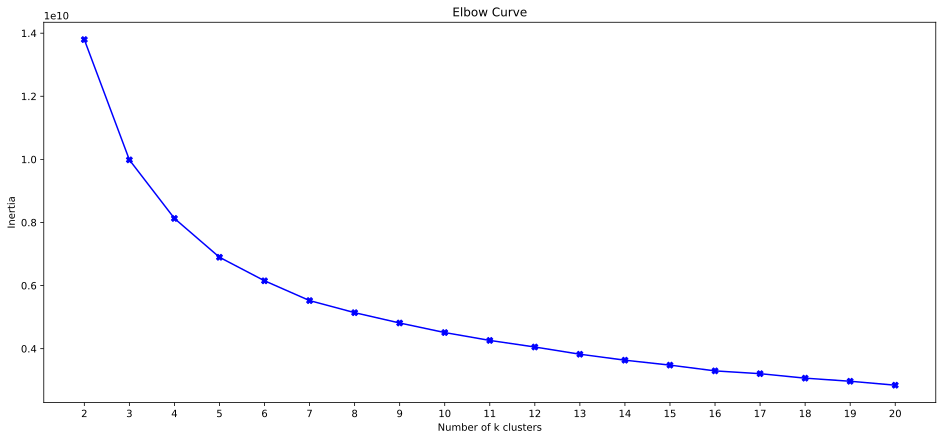

In [63]:
# Optimal k of Clusters using Elbow Method
elbow_ls = []
for i in range(2,21):
  kmeans = KMeans(n_clusters=i, random_state=0).fit(imputed_data.loc[:, imputed_data.columns != 'died'])
  elbow_ls.append(kmeans.inertia_)
  print("For cluster {}, inertia_ = {}".format(i, kmeans.inertia_))


fig = plt.figure(figsize=(16,7))
plt.plot(range(2,21),elbow_ls,'-bX')
plt.xticks(range(2,21))
plt.title('Elbow Curve')
plt.xlabel('Number of k clusters')
plt.ylabel('Inertia')
plt.show()

For cluster 2, The average silhouette_score = 0.9571700789857477
For cluster 3, The average silhouette_score = 0.8964997152232617
For cluster 4, The average silhouette_score = 0.5193415264453697
For cluster 5, The average silhouette_score = 0.4528078381493202
For cluster 6, The average silhouette_score = 0.35100312951497625
For cluster 7, The average silhouette_score = 0.3499546393148703
For cluster 8, The average silhouette_score = 0.27810858628317925
For cluster 9, The average silhouette_score = 0.23239487940827117
For cluster 10, The average silhouette_score = 0.2322470604967738
For cluster 11, The average silhouette_score = 0.19331825835538496
For cluster 12, The average silhouette_score = 0.19402134113645156
For cluster 13, The average silhouette_score = 0.2063613014848771
For cluster 14, The average silhouette_score = 0.21459071727785892
For cluster 15, The average silhouette_score = 0.20700654460059095
For cluster 16, The average silhouette_score = 0.21519323794276657
For cluste

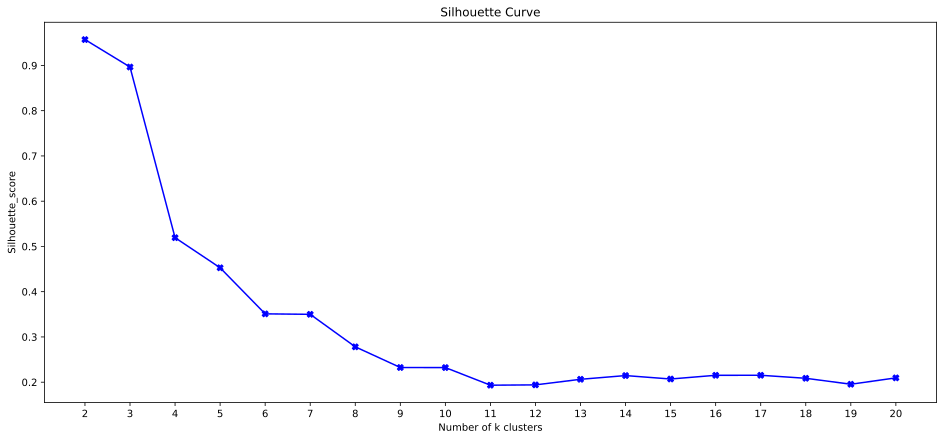

In [46]:
# Optimal k of Clusters using silhouette score Method
from sklearn.metrics import silhouette_score
silhouette_ls = []
for i in range(2,21):
  cluster_labels = KMeans(n_clusters=i, random_state=0).fit_predict(imputed_data.loc[:, imputed_data.columns != 'died'])
  silhouette_avg = silhouette_score(imputed_data.loc[:, imputed_data.columns != 'died'], cluster_labels)
  silhouette_ls.append(silhouette_avg)
  print("For {} clusters, The average silhouette_score = {}".format(i, silhouette_avg))

fig = plt.figure(figsize=(16,7))
plt.plot(range(2,21),silhouette_ls,'-bX')
plt.xticks(range(2,21))
plt.title('Silhouette Curve')
plt.xlabel('Number of k clusters')
plt.ylabel('Silhouette_score')
plt.show()

###Optimal K:
As for the elbow method, the optimal k = 5 (Somewhere between 4-6. The tip of the "elbow") </br>
As for silhouette, the optimal k = 2

#3. Describe the results


###Describe the distributions of demographic features:

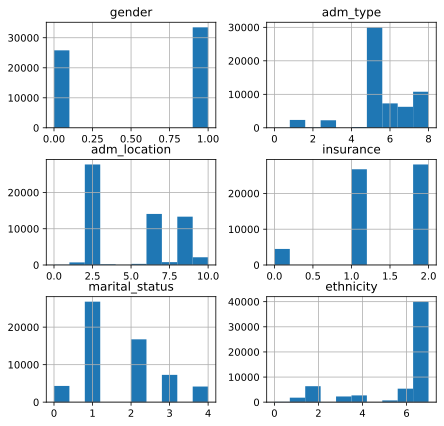

In [47]:
#describe for the overall data set together
imputed_data[['gender', 'adm_type', 'adm_location', 'insurance', 'marital_status', 'ethnicity']].hist(figsize = (7,7))
plt.show()

In [59]:
#set cluster labels
imputed_data['cluster'] = cluster_labels

Distributions of demographic features for cluster 0


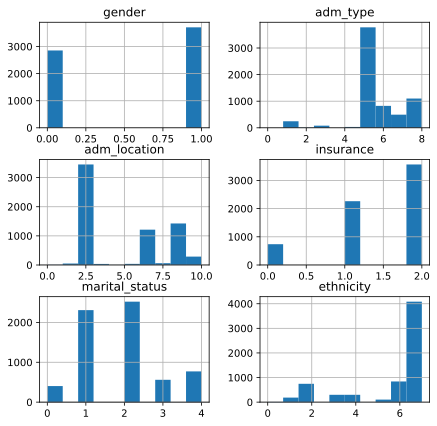

Distributions of demographic features for cluster 1


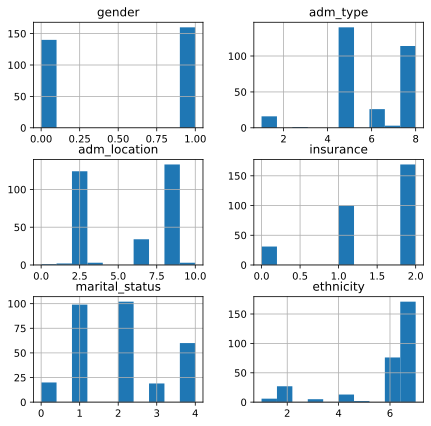

Distributions of demographic features for cluster 2


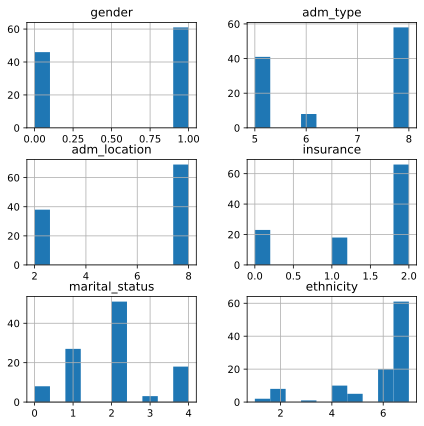

Distributions of demographic features for cluster 3


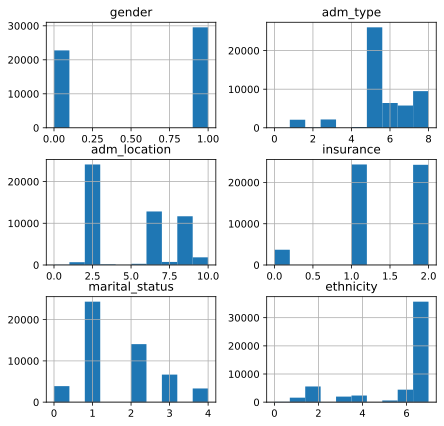

In [60]:
#describe for each cluster seperatly
for cluster_label in range(4):
    print('Distributions of demographic features for cluster',cluster_label)
    data_for_cluster = imputed_data.loc[imputed_data['cluster'] == cluster_label]
    data_for_cluster[['gender', 'adm_type', 'adm_location', 'insurance', 'marital_status', 'ethnicity']].hist(figsize = (7,7))
    plt.show()

###Describe what is the death probability of each cluster, and compare that to the overall probability of death:

In [62]:
overall_death_prob = imputed_data.loc[imputed_data['died'] == 1].shape[0] / imputed_data.shape[0]
print('Overall death probability:', overall_death_prob)
for cluster_label in range(4):
    data_for_cluster = imputed_data.loc[imputed_data['cluster'] == cluster_label]
    death_prob = data_for_cluster.loc[data_for_cluster['died'] == 1].shape[0] / data_for_cluster.shape[0]
    print('Death probability for cluster',cluster_label, ':', death_prob)

Overall death probability: 0.11117670872410769
Death probability for cluster 0 : 0.17946374162096282
Death probability for cluster 1 : 0.35
Death probability for cluster 2 : 0.2616822429906542
Death probability for cluster 3 : 0.10093093494924779


#4.CDSS:

As it can be seen in the histograms that the only demographic features that significantly changed are addmision type, addmission location, insurance, and martial status: </br>
####**cluster 0**- Combined mostly with patients with addmission type of EW EMER. Also most of the admission location are at EMERGENCY ROOM</br>
####**cluster 1**- Combined mostly with patients with addmission type of EW EMER and URGENT. Also here the are a lot of addmission location at EMERGENCY ROOM, But the highest quantity of addmission locations are TRANSFER FROM HOSPITAL</br>
####**cluster 2**- Combined mostly with patients with martial status of SINGLE, While in the other clusters the quantity of married people is at least as the singles.</br>
####**cluster 3**- Combined mostly with patients with insurance of Medicare and Other, While in the other cluster most of the patients are in insurance=other (no Medicare or Medicade), which can tell about may be diffrent kind of population at another socio-economic level.</br>

*Also the death probability of cluster 3 is the lowest, may be looking for way to bring patients closer to this cluster can lower mortality between patients. But it's important to say that correlation does not imply causation, and other hidden things can be the reason that this cluster have the lowest mortality precent.

*something else that is important to say that here I took only addmisions which have one of the most common labs so i skipped a lot of addmissions which i guess will map to their own (biggest) cluster. But I choose to eliminate them because the colab session crash due to memory issue, and also I think they are missing too much information and because there are so many of them it can create an imbalance in the data and hurt the modeling and the ability to draw conclusions


In [83]:
print('highest quantity of addmission type for cluster 0:', le_arr[1].classes_[5])
print('highest quantity of addmission location for cluster 0:', le_arr[2].classes_[2])

print('highest quantity of addmission type for cluster 1:', le_arr[1].classes_[5], le_arr[1].classes_[8])
print('highest quantity of addmission location for cluster 1:', le_arr[2].classes_[8])

print('highest quantity of martial status for cluster 2:', le_arr[4].classes_[1], le_arr[4].classes_[2])
print('highest quantity of insurance for cluster 3:', le_arr[3].classes_[1], le_arr[3].classes_[2])

highest quantity of addmission type for cluster 0: EW EMER.
highest quantity of addmission location for cluster 0: EMERGENCY ROOM
highest quantity of addmission type for cluster 1: EW EMER. URGENT
highest quantity of addmission location for cluster 1: TRANSFER FROM HOSPITAL
highest quantity of martial status for cluster 2: MARRIED SINGLE
highest quantity of insurance for cluster 3: Medicare Other
